# Import libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report,confusion_matrix

import cv2
import os

import numpy as np
import pandas as pd

print(tf.__version__)
print("data\yes//2491975_1119775.jpg")

2.19.0
data\yes//2491975_1119775.jpg


# Loading data

In [2]:
labels = ['no', 'yes'] # yes: green electro parking spot # 'no' = 0, 'yes' = 1

img_size = 250  # Zielgrösse Bilder        

def get_data(data_dir):
    X = []  # Bilddaten
    y = []  # zugehörigen Labels 0 oder 1 
    
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[..., ::-1]    # Bild einlesen, in RGB umwandeln 
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Bild auf einheitliche Grösse skalieren
                X.append(resized_arr)
                y.append(class_num)
            except Exception as e:
                print(f"Fehler bei {img}: {e}")

    return np.array(X), np.array(y)

# alle Daten laden 
x_data, y_data = get_data('data')   # X=Bild, y=Label, 0 für no, 1 für yes
print("Gesamtdaten:", x_data.shape, y_data.shape)

Gesamtdaten: (600, 250, 250, 3) (600,)


# Data Preprocessing, Data Augmentation and Visualization 

In [3]:
# Normalisieren --> Pixelwerte von 0-255 enspricht 0-1
x_data = x_data / 255.0

# Labels als float32 für binary_crossentropy
y_data = y_data.astype('float32')

# Bilder drehen und spiegel aus 1 Orginalbild -> 12 Testbilder 
def rotate_and_flip_images(x, y):
    x_aug, y_aug = [], []
    for img, label in zip(x, y):
        for k in range(4):  # 0°, 90°, 180°, 270°
            rotated = np.rot90(img, k=k)
            x_aug.append(rotated); y_aug.append(label)
            #x_aug.append(np.fliplr(rotated)); y_aug.append(label)  # horizontal spiegeln
            #x_aug.append(np.flipud(rotated)); y_aug.append(label)  # vertikal spiegeln
    return np.array(x_aug), np.array(y_aug)

# Define the Model

In [4]:
def create_model():
    model = Sequential()

    # 1. Convolutional Layer
    model.add(Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(250, 250, 3)))
    model.add(BatchNormalization())  # Normalize after convolution
    model.add(MaxPool2D())

    # 2. Convolutional Layer
    model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(BatchNormalization())  # Normalize after convolution
    model.add(MaxPool2D())

    # 3. Convolutional Layer + Dropout to prevent overfitting
    model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(BatchNormalization())  # Normalize after convolution
    model.add(MaxPool2D())
    model.add(Dropout(0.4))

    # Global Average Pooling instead of Flatten
    model.add(GlobalAveragePooling2D())  # Reduces the size of the output (fewer parameters)

    # Dense Layer
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.3))  # Dropout to prevent overfitting

    # Output Layer (Sigmoid for binary classification)
    model.add(Dense(1, activation="sigmoid"))

    # Model Summary
    model.summary()

    # Optimizer and Callbacks
    optimizer = Adam(learning_rate=0.0001)  # Adjust learning rate for better convergence

    # Compile the Model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [5]:
def train_model(model, x_train, y_train, x_val, y_val, batch_size=8, epochs=30, callbacks=None):
    
    # Define default callbacks if none provided
    if callbacks is None:
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
        ]

    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    return history


# K-folds Schleife


Fold 1 Datenübersicht:


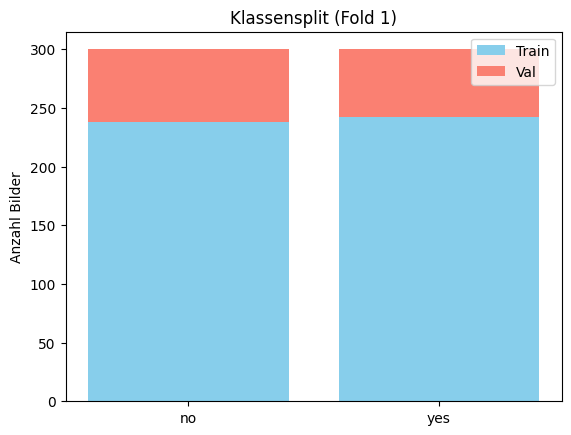

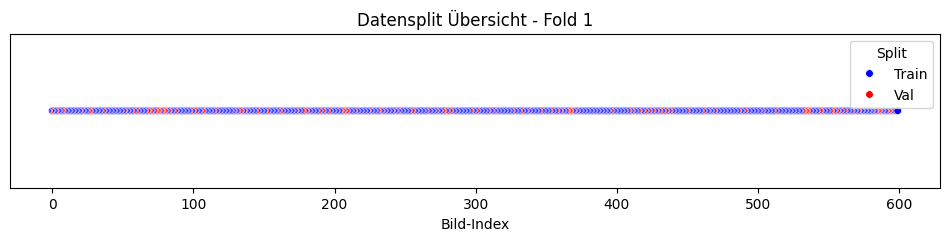

Train shape: (480, 250, 250, 3) (480,)
Val shape: (120, 250, 250, 3) (120,)

Label-Beispiel1: 0 → no
Label-Beispiel2: 1 → yes

Länge Trainingsdaten: 480
Länge Labels: 480
Nach Augmentation: (1920, 250, 250, 3) (1920,)


c:\Users\ruegg\anaconda3\envs\sbdeps\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 250, 250, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 250, 250, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 62, 62, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,785 (432.75 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5552 - loss: 0.6774
Epoch 1: val_accuracy improved from -inf to 0.55000, saving model to model_fold_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.5565 - loss: 0.6765 - val_accuracy: 0.5500 - val_loss: 0.6908 - learning_rate: 1.0000e-04
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7296 - loss: 0.5353
Epoch 2: val_accuracy did not improve from 0.55000
60/60 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.7293 - loss: 0.5355 - val_accuracy: 0.5167 - val_loss: 0.6859 - learning_rate: 1.0000e-04
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7424 - loss: 0.5213
Epoch 3: val_accuracy did not improve from 0.55000
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7423 - loss: 0.5212 - val_accuracy: 0.5083 - val_loss: 0.6841 - learning_rate: 1.0000e-04
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7737 - loss: 0.4977
Epoch 4: val_accuracy did not improve from 0.55000
60/60 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.7735 - loss: 0.4977 - val_accuracy: 0.5167 - val_loss: 0.6834 - learning_rate: 1.0000e-04
Epoch 5/15
60/60 ━━━━━━━━━

60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7900 - loss: 0.4545 - val_accuracy: 0.5750 - val_loss: 0.6613 - learning_rate: 1.0000e-04
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8239 - loss: 0.4070
Epoch 7: val_accuracy improved from 0.57500 to 0.62500, saving model to model_fold_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8238 - loss: 0.4072 - val_accuracy: 0.6250 - val_loss: 0.6186 - learning_rate: 1.0000e-04
Epoch 8/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8194 - loss: 0.4038
Epoch 8: val_accuracy improved from 0.62500 to 0.66667, saving model to model_fold_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8195 - loss: 0.4039 - val_accuracy: 0.6667 - val_loss: 0.5900 - learning_rate: 1.0000e-04
Epoch 9/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8438 - loss: 0.3813
Epoch 9: val_accuracy improved from 0.66667 to 0.71667, saving model to model_fold_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8438 - loss: 0.3811 - val_accuracy: 0.7167 - val_loss: 0.5633 - learning_rate: 1.0000e-04
Epoch 10/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8369 - loss: 0.3791
Epoch 10: val_accuracy improved from 0.71667 to 0.79167, saving model to model_fold_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8370 - loss: 0.3790 - val_accuracy: 0.7917 - val_loss: 0.5038 - learning_rate: 1.0000e-04
Epoch 11/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8584 - loss: 0.3459
Epoch 11: val_accuracy did not improve from 0.79167
60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8582 - loss: 0.3460 - val_accuracy: 0.7833 - val_loss: 0.4586 - learning_rate: 1.0000e-04
Epoch 12/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8765 - loss: 0.3209
Epoch 12: val_accuracy did not improve from 0.79167
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8763 - loss: 0.3211 - val_accuracy: 0.7917 - val_loss: 0.4326 - learning_rate: 1.0000e-04
Epoch 13/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8667 - loss: 0.3410
Epoch 13: val_accuracy did not improve from 0.79167
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8666 - loss: 0.3411 - val_accuracy: 0.6917 - val_loss: 0.5051 - learning_rate: 1.0000e-04
Epoch 14/15
60/60 ━━

60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8745 - loss: 0.3043 - val_accuracy: 0.8167 - val_loss: 0.5104 - learning_rate: 1.0000e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step
                        precision    recall  f1-score   support

  kein E-Parkplatz (0)       0.88      0.74      0.81        62
grüner E-Parkplatz (1)       0.76      0.90      0.83        58

              accuracy                           0.82       120
             macro avg       0.82      0.82      0.82       120
          weighted avg       0.83      0.82      0.82       120



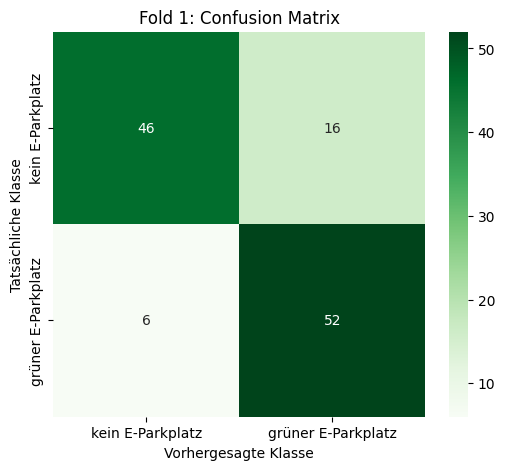

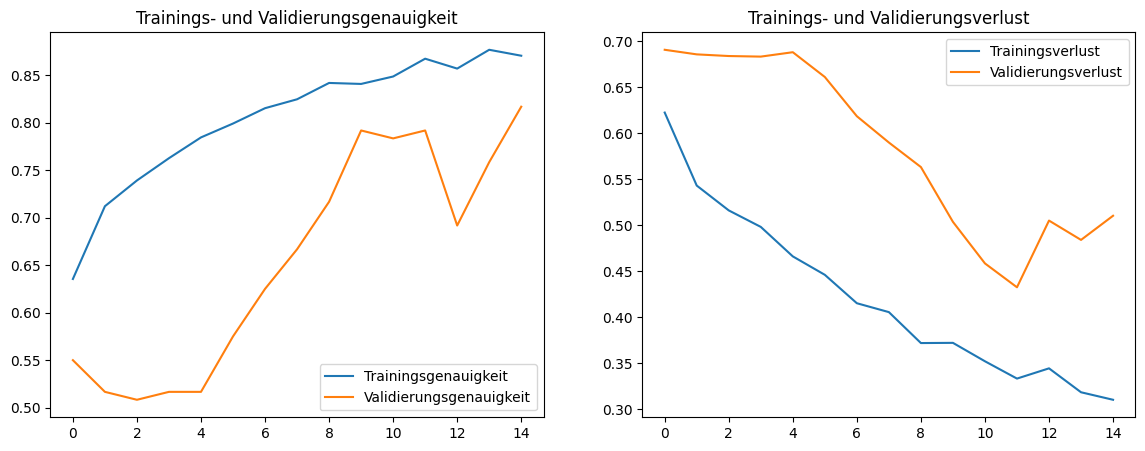


Fold 2 Datenübersicht:


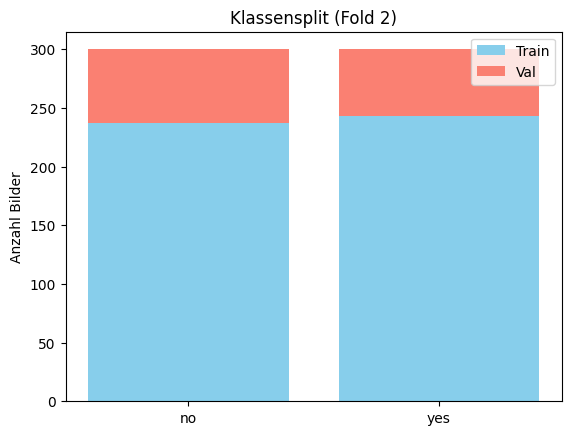

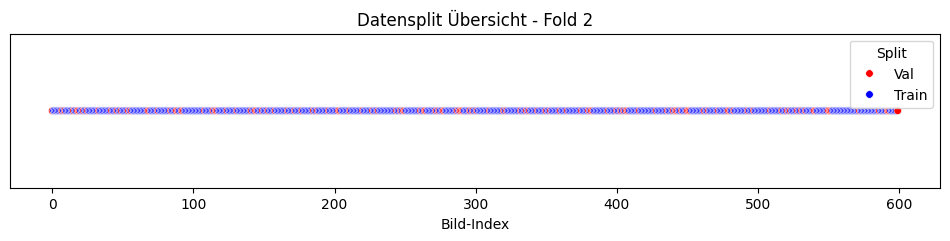

Train shape: (480, 250, 250, 3) (480,)
Val shape: (120, 250, 250, 3) (120,)

Label-Beispiel1: 0 → no
Label-Beispiel2: 1 → yes

Länge Trainingsdaten: 480
Länge Labels: 480
Nach Augmentation: (1920, 250, 250, 3) (1920,)


c:\Users\ruegg\anaconda3\envs\sbdeps\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 250, 250, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 250, 250, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 62, 62, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 62, 62, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,785 (432.75 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6503 - loss: 0.6417
Epoch 1: val_accuracy improved from -inf to 0.52500, saving model to model_fold_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.6507 - loss: 0.6412 - val_accuracy: 0.5250 - val_loss: 0.6916 - learning_rate: 1.0000e-04
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7295 - loss: 0.5435
Epoch 2: val_accuracy did not improve from 0.52500
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7295 - loss: 0.5433 - val_accuracy: 0.5250 - val_loss: 0.6919 - learning_rate: 1.0000e-04
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7754 - loss: 0.4963
Epoch 3: val_accuracy did not improve from 0.52500
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7753 - loss: 0.4964 - val_accuracy: 0.5250 - val_loss: 0.6985 - learning_rate: 1.0000e-04
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7869 - loss: 0.4875
Epoch 4: val_accuracy did not improve from 0.52500
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7869 - loss: 0.4873 - val_accuracy: 0.5250 - val_loss: 0.6810 - learning_rate: 1.0000e-04
Epoch 5/15
60/60 ━━━━━━━━━

60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7910 - loss: 0.4594 - val_accuracy: 0.5583 - val_loss: 0.6628 - learning_rate: 1.0000e-04
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8125 - loss: 0.4297
Epoch 6: val_accuracy improved from 0.55833 to 0.62500, saving model to model_fold_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8126 - loss: 0.4297 - val_accuracy: 0.6250 - val_loss: 0.6325 - learning_rate: 1.0000e-04
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8261 - loss: 0.4128
Epoch 7: val_accuracy improved from 0.62500 to 0.69167, saving model to model_fold_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8260 - loss: 0.4128 - val_accuracy: 0.6917 - val_loss: 0.6007 - learning_rate: 1.0000e-04
Epoch 8/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8535 - loss: 0.3755
Epoch 8: val_accuracy did not improve from 0.69167
60/60 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.8532 - loss: 0.3757 - val_accuracy: 0.6833 - val_loss: 0.5677 - learning_rate: 1.0000e-04
Epoch 9/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8344 - loss: 0.3860
Epoch 9: val_accuracy did not improve from 0.69167
60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8344 - loss: 0.3859 - val_accuracy: 0.6667 - val_loss: 0.5547 - learning_rate: 1.0000e-04
Epoch 10/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8446 - loss: 0.3619
Epoch 10: val_accuracy improved from 0.69167 to 0.74167, saving model to model_fold_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8445 - loss: 0.3619 - val_accuracy: 0.7417 - val_loss: 0.5022 - learning_rate: 1.0000e-04
Epoch 11/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8559 - loss: 0.3595
Epoch 11: val_accuracy improved from 0.74167 to 0.77500, saving model to model_fold_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8559 - loss: 0.3594 - val_accuracy: 0.7750 - val_loss: 0.4469 - learning_rate: 1.0000e-04
Epoch 12/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8576 - loss: 0.3510
Epoch 12: val_accuracy improved from 0.77500 to 0.79167, saving model to model_fold_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8576 - loss: 0.3509 - val_accuracy: 0.7917 - val_loss: 0.4272 - learning_rate: 1.0000e-04
Epoch 13/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8586 - loss: 0.3349
Epoch 13: val_accuracy improved from 0.79167 to 0.89167, saving model to model_fold_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8586 - loss: 0.3349 - val_accuracy: 0.8917 - val_loss: 0.3669 - learning_rate: 1.0000e-04
Epoch 14/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8846 - loss: 0.3135
Epoch 14: val_accuracy did not improve from 0.89167
60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8846 - loss: 0.3134 - val_accuracy: 0.8500 - val_loss: 0.3854 - learning_rate: 1.0000e-04
Epoch 15/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8898 - loss: 0.2838
Epoch 15: val_accuracy did not improve from 0.89167
60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8895 - loss: 0.2841 - val_accuracy: 0.8583 - val_loss: 0.3387 - learning_rate: 1.0000e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step
                        precision    recall  f1-score   support

  kein E-Parkplatz (0)       0.95      0.84      0.89        63
grüner E-Parkplatz (1)       0.84      0.95      0.89        57

              accuracy                           0.89       120
  

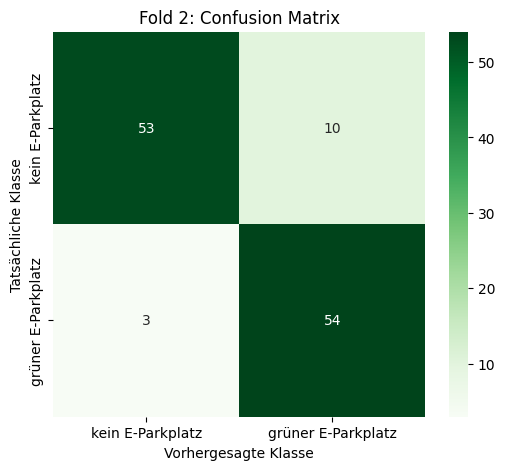

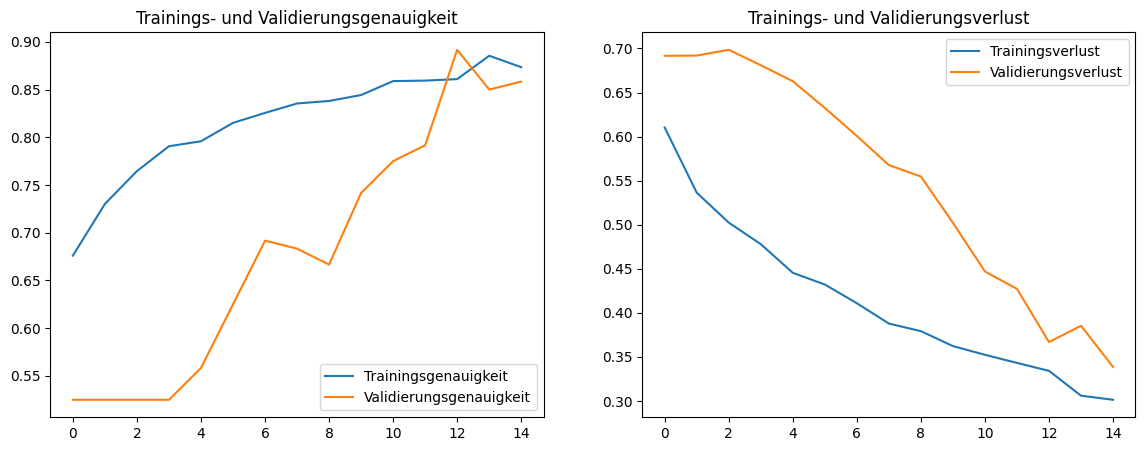


Fold 3 Datenübersicht:


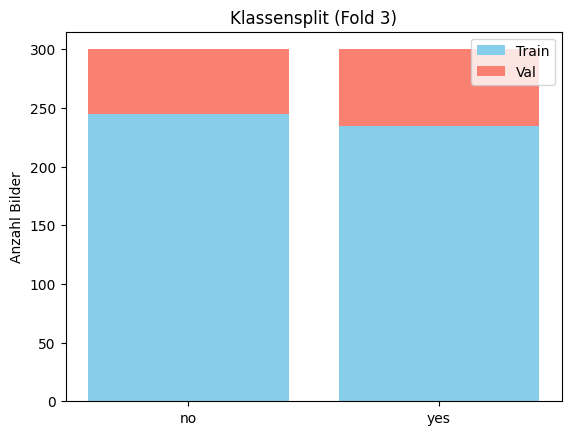

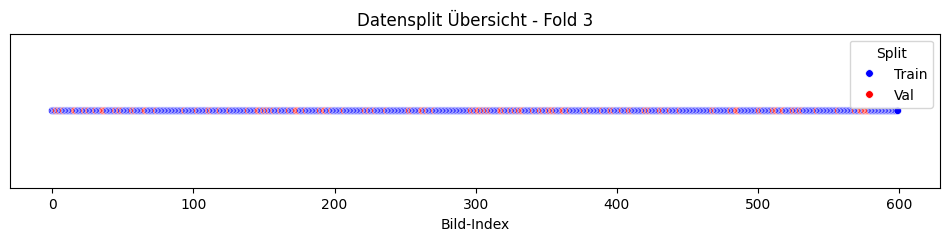

Train shape: (480, 250, 250, 3) (480,)
Val shape: (120, 250, 250, 3) (120,)

Label-Beispiel1: 0 → no
Label-Beispiel2: 1 → yes

Länge Trainingsdaten: 480
Länge Labels: 480
Nach Augmentation: (1920, 250, 250, 3) (1920,)


c:\Users\ruegg\anaconda3\envs\sbdeps\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 250, 250, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 250, 250, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 62, 62, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 62, 62, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,785 (432.75 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6125 - loss: 0.6461
Epoch 1: val_accuracy improved from -inf to 0.45833, saving model to model_fold_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.6132 - loss: 0.6454 - val_accuracy: 0.4583 - val_loss: 0.7032 - learning_rate: 1.0000e-04
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7073 - loss: 0.5479
Epoch 2: val_accuracy did not improve from 0.45833
60/60 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.7075 - loss: 0.5478 - val_accuracy: 0.4583 - val_loss: 0.7146 - learning_rate: 1.0000e-04
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7596 - loss: 0.4968
Epoch 3: val_accuracy did not improve from 0.45833
60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7596 - loss: 0.4968 - val_accuracy: 0.4583 - val_loss: 0.7365 - learning_rate: 1.0000e-04
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7907 - loss: 0.4716
Epoch 4: val_accuracy did not improve from 0.45833
60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7906 - loss: 0.4715 - val_accuracy: 0.4583 - val_loss: 0.7440 - learning_rate: 1.0000e-04
Epoch 5/15
60/60 ━━━━━━━━

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000024D5752FEC0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step
                        precision    recall  f1-score   support

  kein E-Parkplatz (0)       0.46      1.00      0.63        55
grüner E-Parkplatz (1)       0.00      0.00      0.00        65

              accuracy                           0.46       120
             macro avg       0.23      0.50      0.31       120
          weighted avg       0.21      0.46      0.29       120



c:\Users\ruegg\anaconda3\envs\sbdeps\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ruegg\anaconda3\envs\sbdeps\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ruegg\anaconda3\envs\sbdeps\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


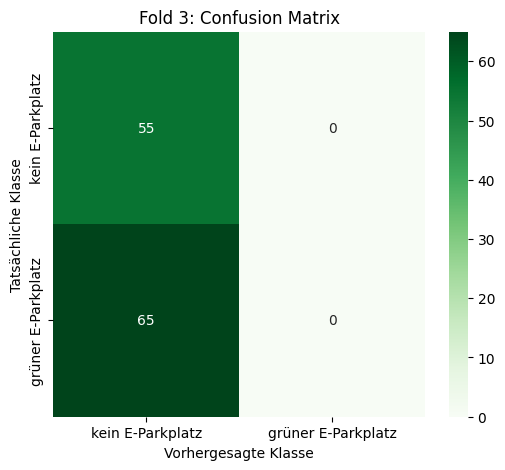

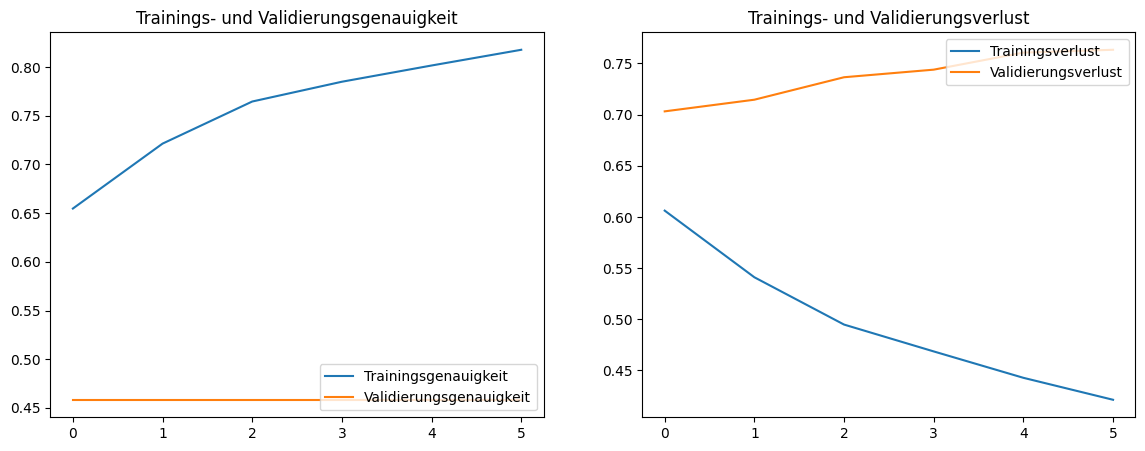


Fold 4 Datenübersicht:


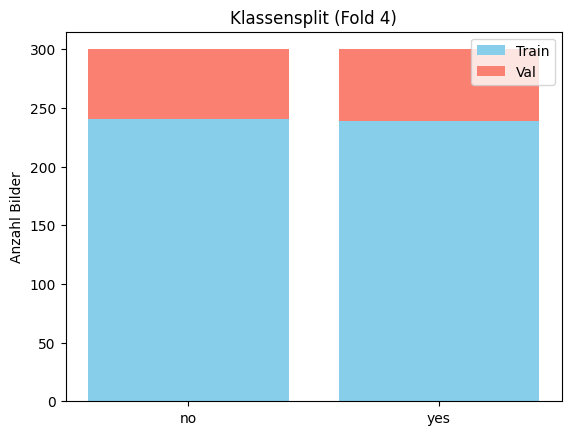

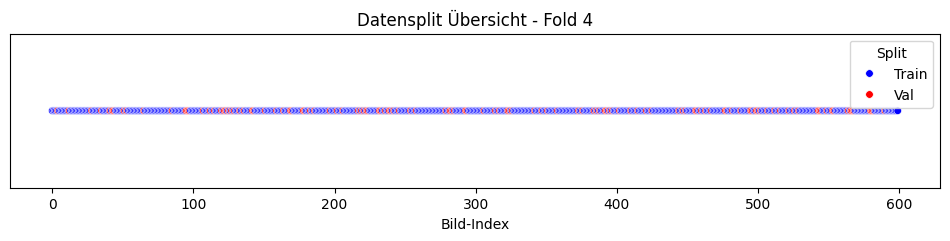

Train shape: (480, 250, 250, 3) (480,)
Val shape: (120, 250, 250, 3) (120,)

Label-Beispiel1: 0 → no
Label-Beispiel2: 1 → yes

Länge Trainingsdaten: 480
Länge Labels: 480
Nach Augmentation: (1920, 250, 250, 3) (1920,)


c:\Users\ruegg\anaconda3\envs\sbdeps\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 250, 250, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 250, 250, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 62, 62, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 62, 62, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,785 (432.75 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6101 - loss: 0.6583
Epoch 1: val_accuracy improved from -inf to 0.51667, saving model to model_fold_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.6109 - loss: 0.6575 - val_accuracy: 0.5167 - val_loss: 0.6929 - learning_rate: 1.0000e-04
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6962 - loss: 0.5781
Epoch 2: val_accuracy improved from 0.51667 to 0.52500, saving model to model_fold_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.6964 - loss: 0.5780 - val_accuracy: 0.5250 - val_loss: 0.6871 - learning_rate: 1.0000e-04
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7229 - loss: 0.5343
Epoch 3: val_accuracy did not improve from 0.52500
60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7229 - loss: 0.5344 - val_accuracy: 0.4917 - val_loss: 0.6922 - learning_rate: 1.0000e-04
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7313 - loss: 0.5328
Epoch 4: val_accuracy did not improve from 0.52500
60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7316 - loss: 0.5325 - val_accuracy: 0.4917 - val_loss: 0.7328 - learning_rate: 1.0000e-04
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7598 - loss: 0.4978
Epoch 5: val_accuracy did not improve from 0.52500
60/60 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.7601 - loss: 0.4977 - val_accuracy: 0.4917 - val_loss: 0.7643 - learning_rate: 1.0000e-04
Epoch 6/15
60/60 ━━━━━━━━

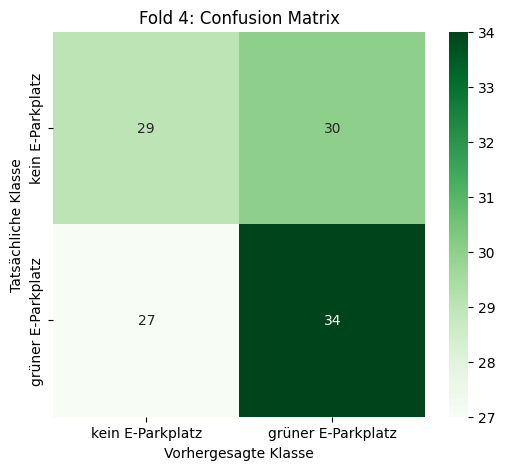

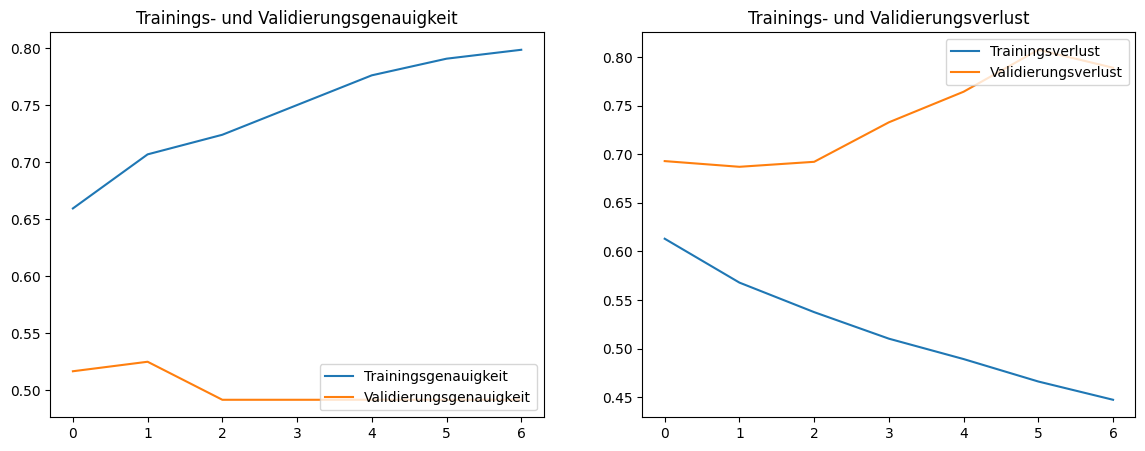


Fold 5 Datenübersicht:


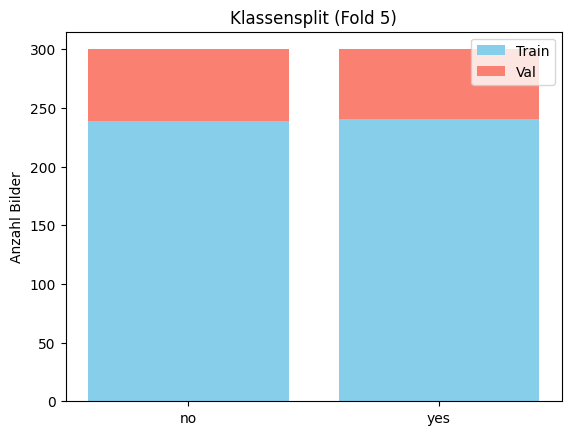

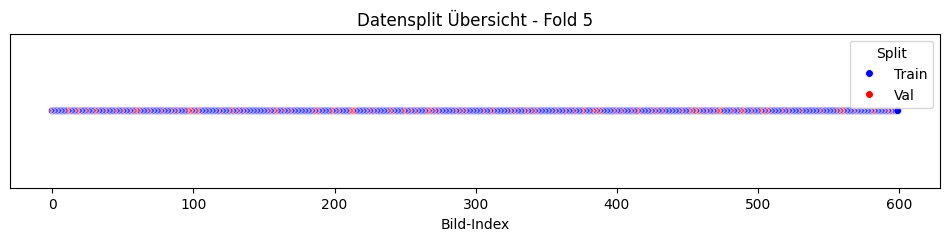

Train shape: (480, 250, 250, 3) (480,)
Val shape: (120, 250, 250, 3) (120,)

Label-Beispiel1: 0 → no
Label-Beispiel2: 1 → yes

Länge Trainingsdaten: 480
Länge Labels: 480
Nach Augmentation: (1920, 250, 250, 3) (1920,)


c:\Users\ruegg\anaconda3\envs\sbdeps\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 250, 250, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 250, 250, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 62, 62, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 62, 62, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,785 (432.75 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5580 - loss: 0.7829
Epoch 1: val_accuracy improved from -inf to 0.49167, saving model to model_fold_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.5586 - loss: 0.7814 - val_accuracy: 0.4917 - val_loss: 0.6967 - learning_rate: 1.0000e-04
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6886 - loss: 0.5885
Epoch 2: val_accuracy improved from 0.49167 to 0.50000, saving model to model_fold_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.6885 - loss: 0.5884 - val_accuracy: 0.5000 - val_loss: 0.6870 - learning_rate: 1.0000e-04
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7175 - loss: 0.5603
Epoch 3: val_accuracy improved from 0.50000 to 0.61667, saving model to model_fold_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.7175 - loss: 0.5603 - val_accuracy: 0.6167 - val_loss: 0.6724 - learning_rate: 1.0000e-04
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7424 - loss: 0.5272
Epoch 4: val_accuracy improved from 0.61667 to 0.70833, saving model to model_fold_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.7424 - loss: 0.5271 - val_accuracy: 0.7083 - val_loss: 0.6644 - learning_rate: 1.0000e-04
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7346 - loss: 0.5176
Epoch 5: val_accuracy did not improve from 0.70833
60/60 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.7349 - loss: 0.5173 - val_accuracy: 0.6750 - val_loss: 0.6467 - learning_rate: 1.0000e-04
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7724 - loss: 0.4824
Epoch 6: val_accuracy did not improve from 0.70833
60/60 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.7725 - loss: 0.4823 - val_accuracy: 0.7083 - val_loss: 0.6302 - learning_rate: 1.0000e-04
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7858 - loss: 0.4597
Epoch 7: val_accuracy improved from 0.70833 to 0.74167, saving model to model_fold_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.7858 - loss: 0.4596 - val_accuracy: 0.7417 - val_loss: 0.5994 - learning_rate: 1.0000e-04
Epoch 8/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8030 - loss: 0.4481
Epoch 8: val_accuracy did not improve from 0.74167
60/60 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.8030 - loss: 0.4481 - val_accuracy: 0.6250 - val_loss: 0.6122 - learning_rate: 1.0000e-04
Epoch 9/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7846 - loss: 0.4303
Epoch 9: val_accuracy improved from 0.74167 to 0.76667, saving model to model_fold_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7849 - loss: 0.4302 - val_accuracy: 0.7667 - val_loss: 0.5325 - learning_rate: 1.0000e-04
Epoch 10/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8090 - loss: 0.4070
Epoch 10: val_accuracy did not improve from 0.76667
60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8092 - loss: 0.4070 - val_accuracy: 0.6583 - val_loss: 0.5890 - learning_rate: 1.0000e-04
Epoch 11/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8491 - loss: 0.3845
Epoch 11: val_accuracy did not improve from 0.76667
60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8490 - loss: 0.3845 - val_accuracy: 0.6417 - val_loss: 0.6031 - learning_rate: 1.0000e-04
Epoch 12/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8303 - loss: 0.3938
Epoch 12: val_accuracy improved from 0.76667 to 0.82500, saving model to model_fold_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8303 - loss: 0.3936 - val_accuracy: 0.8250 - val_loss: 0.4729 - learning_rate: 1.0000e-04
Epoch 13/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8420 - loss: 0.3803
Epoch 13: val_accuracy did not improve from 0.82500
60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8420 - loss: 0.3802 - val_accuracy: 0.6917 - val_loss: 0.5974 - learning_rate: 1.0000e-04
Epoch 14/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8670 - loss: 0.3327
Epoch 14: val_accuracy did not improve from 0.82500
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8668 - loss: 0.3330 - val_accuracy: 0.6333 - val_loss: 0.7029 - learning_rate: 1.0000e-04
Epoch 15/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8396 - loss: 0.3687
Epoch 15: val_accuracy improved from 0.82500 to 0.84167, saving model to model_fold_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8397 - loss: 0.3684 - val_accuracy: 0.8417 - val_loss: 0.4407 - learning_rate: 1.0000e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step
                        precision    recall  f1-score   support

  kein E-Parkplatz (0)       0.88      0.80      0.84        61
grüner E-Parkplatz (1)       0.81      0.88      0.85        59

              accuracy                           0.84       120
             macro avg       0.84      0.84      0.84       120
          weighted avg       0.84      0.84      0.84       120



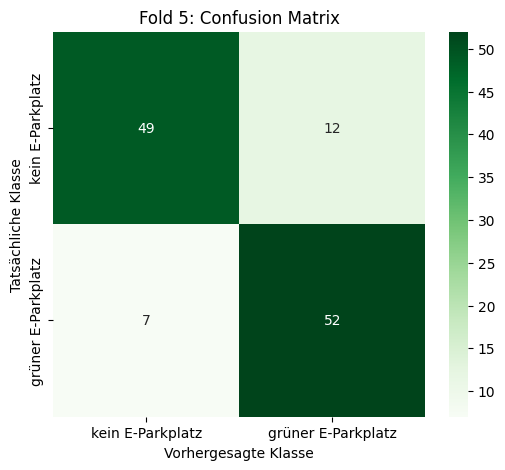

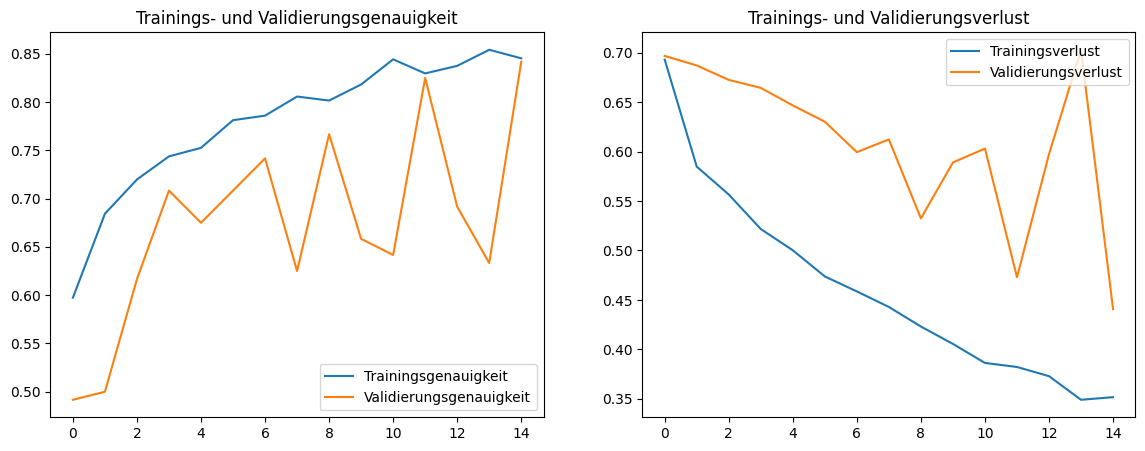

In [ ]:
# K-Fold vorbereiten - Cross Validation 
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_no = 1
acc_per_fold = []
loss_per_fold = []

for train_index, val_index in kf.split(x_data):
    print(f'\n====================')
    print(f'Fold {fold_no} Datenübersicht:')

    # Aufteilen in Training / Validation
    x_train, x_val = x_data[train_index], x_data[val_index]
    y_train, y_val = y_data[train_index], y_data[val_index]

    # Ursprüngliche Labels (ohne Augmentation!) → Verteilung im Original-Split  
    train_labels = y_data[train_index].astype(int)
    val_labels = y_data[val_index].astype(int)

    # Anzahl pro Klasse
    train_no = np.sum(train_labels == 0)
    train_yes = np.sum(train_labels == 1)
    val_no = np.sum(val_labels == 0)
    val_yes = np.sum(val_labels == 1)

    labels_classes = ['no', 'yes']
    train_counts = [train_no, train_yes]
    val_counts = [val_no, val_yes]

    x = np.arange(len(labels_classes))

    fig, ax = plt.subplots()
    ax.bar(x, train_counts, label='Train', color='skyblue')
    ax.bar(x, val_counts, bottom=train_counts, label='Val', color='salmon')

    ax.set_ylabel('Anzahl Bilder')
    ax.set_title(f'Klassensplit (Fold {fold_no})')
    ax.set_xticks(x)
    ax.set_xticklabels(labels_classes)
    ax.legend()

    plt.show()
   
    
    # Visualisieren, welche Bilder train / val sind
    split_labels = []
    for idx in range(len(x_data)):
        if idx in train_index:
            split_labels.append('Train')
        elif idx in val_index:
            split_labels.append('Val')
        else:
            split_labels.append('Unknown')

    df = pd.DataFrame({'Index': range(len(x_data)), 'Split': split_labels})

    # Plot
    plt.figure(figsize=(12, 2))
    sns.scatterplot(data=df, x='Index', y=[1]*len(df), hue='Split', palette={'Train': 'blue', 'Val': 'red'}, legend='full', s=30)
    plt.title(f'Datensplit Übersicht - Fold {fold_no}')
    plt.yticks([])
    plt.xlabel('Bild-Index')
    plt.show()


    # Shape vor Augmentation 
    print("Train shape:", x_train.shape, y_train.shape)
    print("Val shape:", x_val.shape, y_val.shape)

    # Beispiel-Labels anzeigen
    print("\nLabel-Beispiel1:", int(y_train[0]), "→", labels[int(y_train[0])])
    print("Label-Beispiel2:", int(y_train[-1]), "→", labels[int(y_train[-1])])

    # Anzahl Daten
    print("\nLänge Trainingsdaten:", len(x_train))
    print("Länge Labels:", len(y_train))

    # Data Augmentation auf Trainingsdaten
    x_train, y_train = rotate_and_flip_images(x_train, y_train)
    print("Nach Augmentation:", x_train.shape, y_train.shape)
    
    # Model erzeugen
    model = create_model()

    # Create callbacks including checkpoint
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
    checkpoint = ModelCheckpoint(
        f'model_fold_{fold_no}.h5', 
        monitor='val_accuracy', 
        save_best_only=True,
        mode='max',
        verbose=1
    )

    callbacks = [early_stop, lr_scheduler, checkpoint]

    history = train_model(
        model, x_train, y_train, x_val, y_val,
        batch_size=32,
        epochs=15,
        callbacks=callbacks
    )

    # laod the best weights
    model.load_weights(f'model_fold_{fold_no}.h5')

# rest of your code ...

    # Bilder der Resultate 

    # Vorhersagen
    predictions = model.predict(x_val)
    predictions = (predictions > 0.5).astype("int32").reshape(-1)
    y_val_int = y_val.astype(int)

    # Classification Report
    print(classification_report(y_val_int, predictions, target_names=['kein E-Parkplatz (0)', 'grüner E-Parkplatz (1)']))

    # Confusion Matrix
    cm = confusion_matrix(y_val_int, predictions)
    labels_cm = ['kein E-Parkplatz', 'grüner E-Parkplatz']

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=labels_cm,
                yticklabels=labels_cm)
    plt.xlabel('Vorhergesagte Klasse')
    plt.ylabel('Tatsächliche Klasse')
    plt.title(f'Fold {fold_no}: Confusion Matrix')
    plt.show()

    # Loss & Accuracy Plot
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Trainingsgenauigkeit')
    plt.plot(epochs_range, val_acc, label='Validierungsgenauigkeit')
    plt.legend(loc='lower right')
    plt.title('Trainings- und Validierungsgenauigkeit')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Trainingsverlust')
    plt.plot(epochs_range, val_loss, label='Validierungsverlust')
    plt.legend(loc='upper right')
    plt.title('Trainings- und Validierungsverlust')

    plt.show()

    # fold_no am Ende des Loops hochzählen
    fold_no += 1




Fold 1 Datenübersicht:


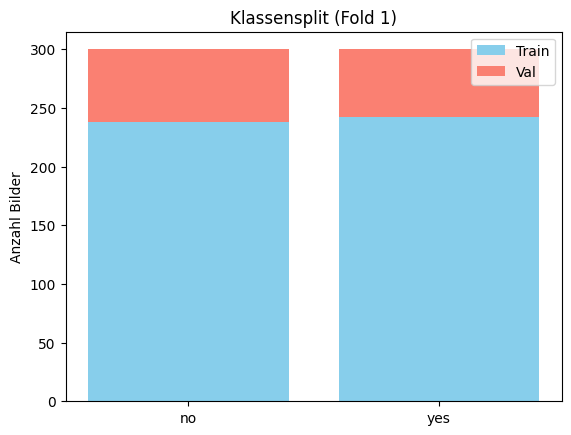

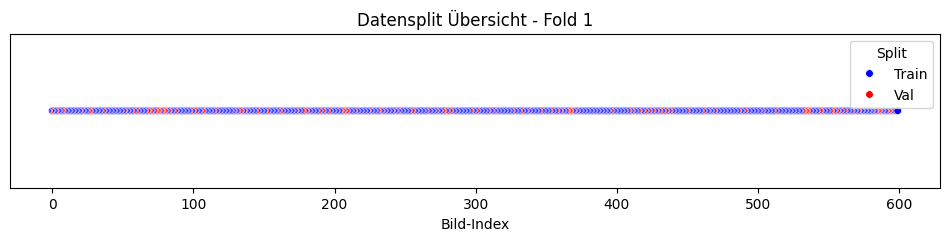

Train shape: (480, 250, 250, 3) (480,)
Val shape: (120, 250, 250, 3) (120,)

Label-Beispiel1: 0 → no
Label-Beispiel2: 1 → yes

Länge Trainingsdaten: 480
Länge Labels: 480
Nach Augmentation: (1920, 250, 250, 3) (1920,)


c:\Users\ruegg\anaconda3\envs\sbdeps\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 250, 250, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 250, 250, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 62, 62, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,785 (432.75 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5552 - loss: 0.6774
Epoch 1: val_accuracy improved from -inf to 0.55000, saving model to model_fold_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.5565 - loss: 0.6765 - val_accuracy: 0.5500 - val_loss: 0.6908 - learning_rate: 1.0000e-04
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7296 - loss: 0.5353
Epoch 2: val_accuracy did not improve from 0.55000
60/60 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.7293 - loss: 0.5355 - val_accuracy: 0.5167 - val_loss: 0.6859 - learning_rate: 1.0000e-04
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7424 - loss: 0.5213
Epoch 3: val_accuracy did not improve from 0.55000
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7423 - loss: 0.5212 - val_accuracy: 0.5083 - val_loss: 0.6841 - learning_rate: 1.0000e-04
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7737 - loss: 0.4977
Epoch 4: val_accuracy did not improve from 0.55000
60/60 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.7735 - loss: 0.4977 - val_accuracy: 0.5167 - val_loss: 0.6834 - learning_rate: 1.0000e-04
Epoch 5/15
60/60 ━━━━━━━━━

60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7900 - loss: 0.4545 - val_accuracy: 0.5750 - val_loss: 0.6613 - learning_rate: 1.0000e-04
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8239 - loss: 0.4070
Epoch 7: val_accuracy improved from 0.57500 to 0.62500, saving model to model_fold_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8238 - loss: 0.4072 - val_accuracy: 0.6250 - val_loss: 0.6186 - learning_rate: 1.0000e-04
Epoch 8/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8194 - loss: 0.4038
Epoch 8: val_accuracy improved from 0.62500 to 0.66667, saving model to model_fold_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8195 - loss: 0.4039 - val_accuracy: 0.6667 - val_loss: 0.5900 - learning_rate: 1.0000e-04
Epoch 9/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8438 - loss: 0.3813
Epoch 9: val_accuracy improved from 0.66667 to 0.71667, saving model to model_fold_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8438 - loss: 0.3811 - val_accuracy: 0.7167 - val_loss: 0.5633 - learning_rate: 1.0000e-04
Epoch 10/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8369 - loss: 0.3791
Epoch 10: val_accuracy improved from 0.71667 to 0.79167, saving model to model_fold_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8370 - loss: 0.3790 - val_accuracy: 0.7917 - val_loss: 0.5038 - learning_rate: 1.0000e-04
Epoch 11/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8584 - loss: 0.3459
Epoch 11: val_accuracy did not improve from 0.79167
60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8582 - loss: 0.3460 - val_accuracy: 0.7833 - val_loss: 0.4586 - learning_rate: 1.0000e-04
Epoch 12/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8765 - loss: 0.3209
Epoch 12: val_accuracy did not improve from 0.79167
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8763 - loss: 0.3211 - val_accuracy: 0.7917 - val_loss: 0.4326 - learning_rate: 1.0000e-04
Epoch 13/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8667 - loss: 0.3410
Epoch 13: val_accuracy did not improve from 0.79167
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8666 - loss: 0.3411 - val_accuracy: 0.6917 - val_loss: 0.5051 - learning_rate: 1.0000e-04
Epoch 14/15
60/60 ━━

60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8745 - loss: 0.3043 - val_accuracy: 0.8167 - val_loss: 0.5104 - learning_rate: 1.0000e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step
                        precision    recall  f1-score   support

  kein E-Parkplatz (0)       0.88      0.74      0.81        62
grüner E-Parkplatz (1)       0.76      0.90      0.83        58

              accuracy                           0.82       120
             macro avg       0.82      0.82      0.82       120
          weighted avg       0.83      0.82      0.82       120



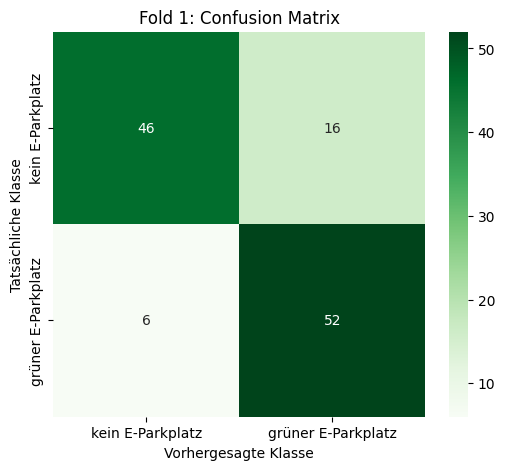

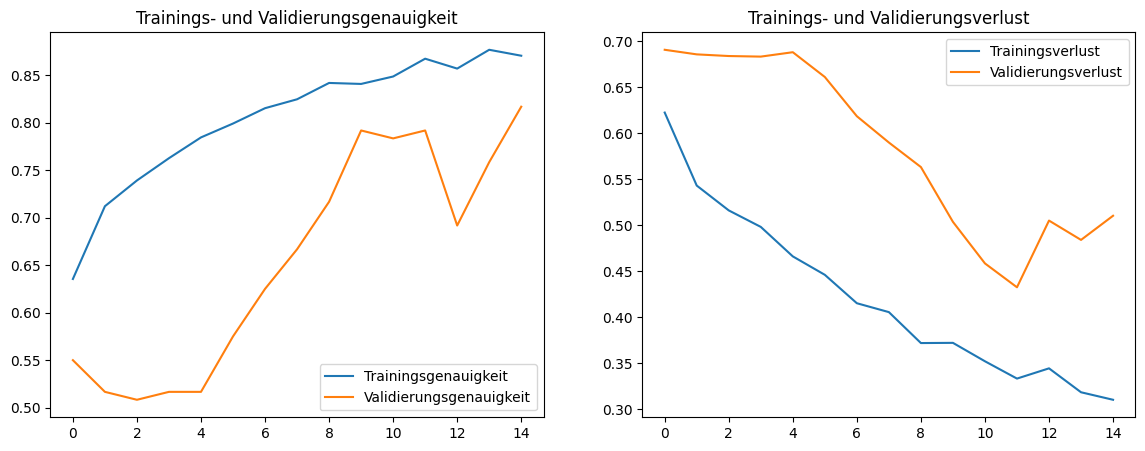


Fold 2 Datenübersicht:


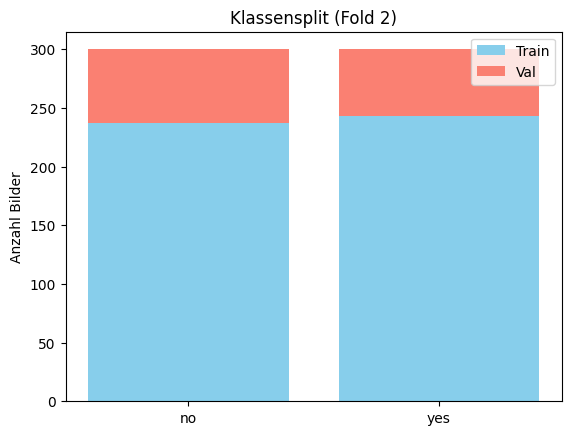

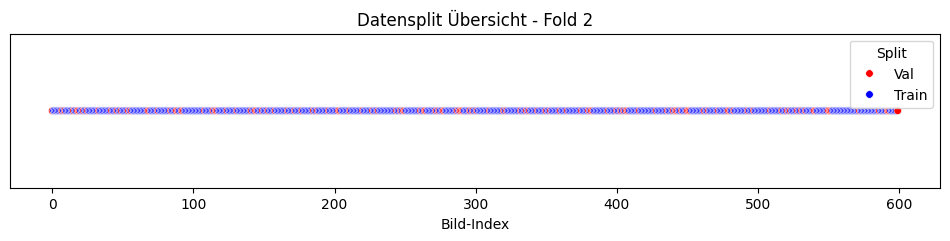

Train shape: (480, 250, 250, 3) (480,)
Val shape: (120, 250, 250, 3) (120,)

Label-Beispiel1: 0 → no
Label-Beispiel2: 1 → yes

Länge Trainingsdaten: 480
Länge Labels: 480
Nach Augmentation: (1920, 250, 250, 3) (1920,)


c:\Users\ruegg\anaconda3\envs\sbdeps\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 250, 250, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 250, 250, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 62, 62, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 62, 62, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,785 (432.75 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6503 - loss: 0.6417
Epoch 1: val_accuracy improved from -inf to 0.52500, saving model to model_fold_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.6507 - loss: 0.6412 - val_accuracy: 0.5250 - val_loss: 0.6916 - learning_rate: 1.0000e-04
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7295 - loss: 0.5435
Epoch 2: val_accuracy did not improve from 0.52500
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7295 - loss: 0.5433 - val_accuracy: 0.5250 - val_loss: 0.6919 - learning_rate: 1.0000e-04
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7754 - loss: 0.4963
Epoch 3: val_accuracy did not improve from 0.52500
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7753 - loss: 0.4964 - val_accuracy: 0.5250 - val_loss: 0.6985 - learning_rate: 1.0000e-04
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7869 - loss: 0.4875
Epoch 4: val_accuracy did not improve from 0.52500
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7869 - loss: 0.4873 - val_accuracy: 0.5250 - val_loss: 0.6810 - learning_rate: 1.0000e-04
Epoch 5/15
60/60 ━━━━━━━━━

60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7910 - loss: 0.4594 - val_accuracy: 0.5583 - val_loss: 0.6628 - learning_rate: 1.0000e-04
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8125 - loss: 0.4297
Epoch 6: val_accuracy improved from 0.55833 to 0.62500, saving model to model_fold_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8126 - loss: 0.4297 - val_accuracy: 0.6250 - val_loss: 0.6325 - learning_rate: 1.0000e-04
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8261 - loss: 0.4128
Epoch 7: val_accuracy improved from 0.62500 to 0.69167, saving model to model_fold_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8260 - loss: 0.4128 - val_accuracy: 0.6917 - val_loss: 0.6007 - learning_rate: 1.0000e-04
Epoch 8/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8535 - loss: 0.3755
Epoch 8: val_accuracy did not improve from 0.69167
60/60 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.8532 - loss: 0.3757 - val_accuracy: 0.6833 - val_loss: 0.5677 - learning_rate: 1.0000e-04
Epoch 9/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8344 - loss: 0.3860
Epoch 9: val_accuracy did not improve from 0.69167
60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8344 - loss: 0.3859 - val_accuracy: 0.6667 - val_loss: 0.5547 - learning_rate: 1.0000e-04
Epoch 10/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8446 - loss: 0.3619
Epoch 10: val_accuracy improved from 0.69167 to 0.74167, saving model to model_fold_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8445 - loss: 0.3619 - val_accuracy: 0.7417 - val_loss: 0.5022 - learning_rate: 1.0000e-04
Epoch 11/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8559 - loss: 0.3595
Epoch 11: val_accuracy improved from 0.74167 to 0.77500, saving model to model_fold_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8559 - loss: 0.3594 - val_accuracy: 0.7750 - val_loss: 0.4469 - learning_rate: 1.0000e-04
Epoch 12/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8576 - loss: 0.3510
Epoch 12: val_accuracy improved from 0.77500 to 0.79167, saving model to model_fold_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8576 - loss: 0.3509 - val_accuracy: 0.7917 - val_loss: 0.4272 - learning_rate: 1.0000e-04
Epoch 13/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8586 - loss: 0.3349
Epoch 13: val_accuracy improved from 0.79167 to 0.89167, saving model to model_fold_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8586 - loss: 0.3349 - val_accuracy: 0.8917 - val_loss: 0.3669 - learning_rate: 1.0000e-04
Epoch 14/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8846 - loss: 0.3135
Epoch 14: val_accuracy did not improve from 0.89167
60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8846 - loss: 0.3134 - val_accuracy: 0.8500 - val_loss: 0.3854 - learning_rate: 1.0000e-04
Epoch 15/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8898 - loss: 0.2838
Epoch 15: val_accuracy did not improve from 0.89167
60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.8895 - loss: 0.2841 - val_accuracy: 0.8583 - val_loss: 0.3387 - learning_rate: 1.0000e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step
                        precision    recall  f1-score   support

  kein E-Parkplatz (0)       0.95      0.84      0.89        63
grüner E-Parkplatz (1)       0.84      0.95      0.89        57

              accuracy                           0.89       120
  

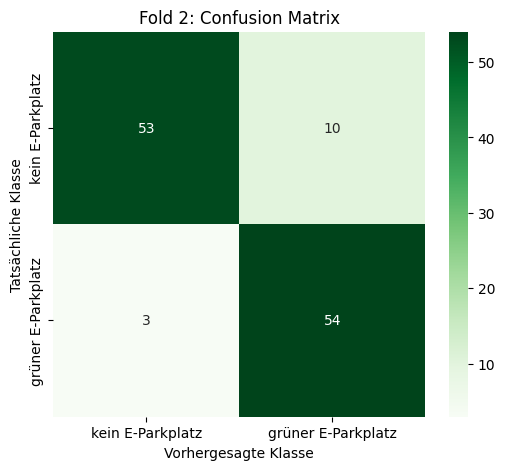

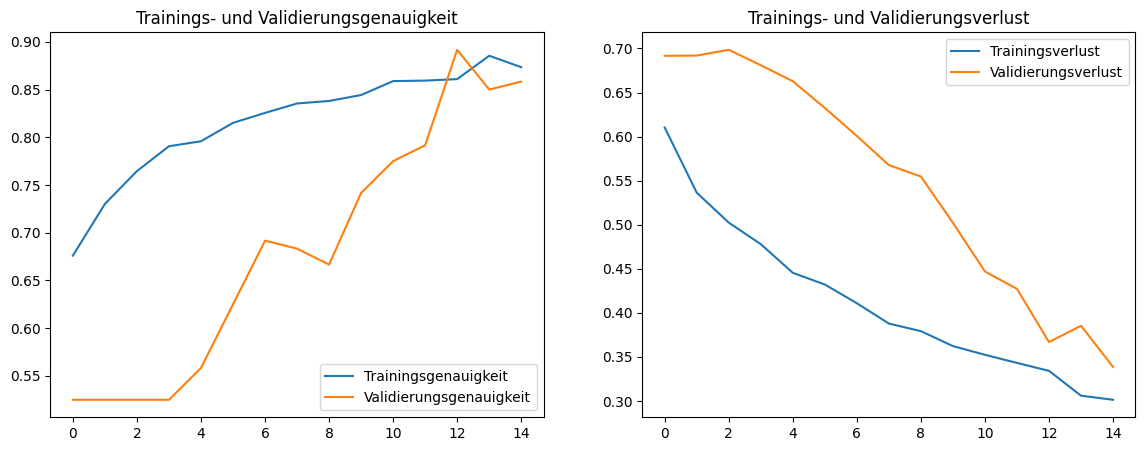


Fold 3 Datenübersicht:


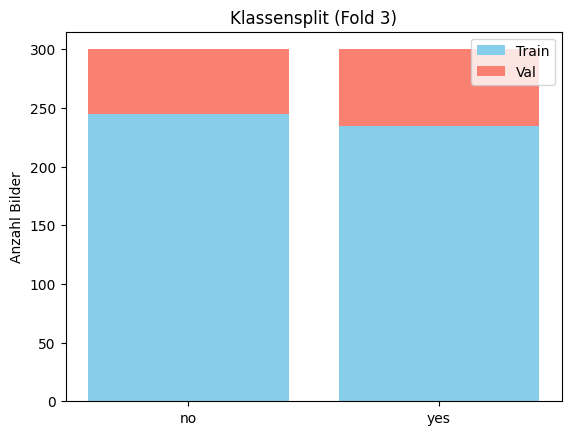

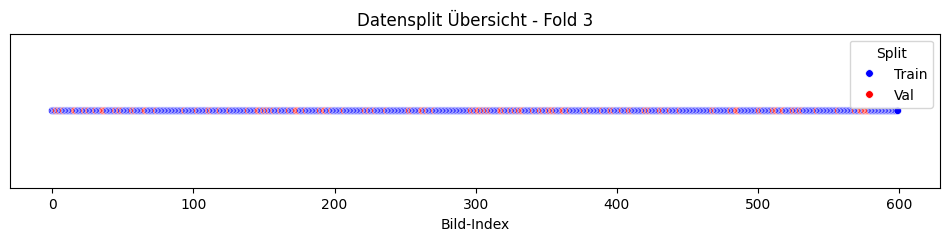

Train shape: (480, 250, 250, 3) (480,)
Val shape: (120, 250, 250, 3) (120,)

Label-Beispiel1: 0 → no
Label-Beispiel2: 1 → yes

Länge Trainingsdaten: 480
Länge Labels: 480
Nach Augmentation: (1920, 250, 250, 3) (1920,)


c:\Users\ruegg\anaconda3\envs\sbdeps\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 250, 250, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 250, 250, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 62, 62, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 62, 62, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,785 (432.75 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6125 - loss: 0.6461
Epoch 1: val_accuracy improved from -inf to 0.45833, saving model to model_fold_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.6132 - loss: 0.6454 - val_accuracy: 0.4583 - val_loss: 0.7032 - learning_rate: 1.0000e-04
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7073 - loss: 0.5479
Epoch 2: val_accuracy did not improve from 0.45833
60/60 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.7075 - loss: 0.5478 - val_accuracy: 0.4583 - val_loss: 0.7146 - learning_rate: 1.0000e-04
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7596 - loss: 0.4968
Epoch 3: val_accuracy did not improve from 0.45833
60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7596 - loss: 0.4968 - val_accuracy: 0.4583 - val_loss: 0.7365 - learning_rate: 1.0000e-04
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7907 - loss: 0.4716
Epoch 4: val_accuracy did not improve from 0.45833
60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7906 - loss: 0.4715 - val_accuracy: 0.4583 - val_loss: 0.7440 - learning_rate: 1.0000e-04
Epoch 5/15
60/60 ━━━━━━━━

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000024D5752FEC0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step
                        precision    recall  f1-score   support

  kein E-Parkplatz (0)       0.46      1.00      0.63        55
grüner E-Parkplatz (1)       0.00      0.00      0.00        65

              accuracy                           0.46       120
             macro avg       0.23      0.50      0.31       120
          weighted avg       0.21      0.46      0.29       120



c:\Users\ruegg\anaconda3\envs\sbdeps\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ruegg\anaconda3\envs\sbdeps\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ruegg\anaconda3\envs\sbdeps\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


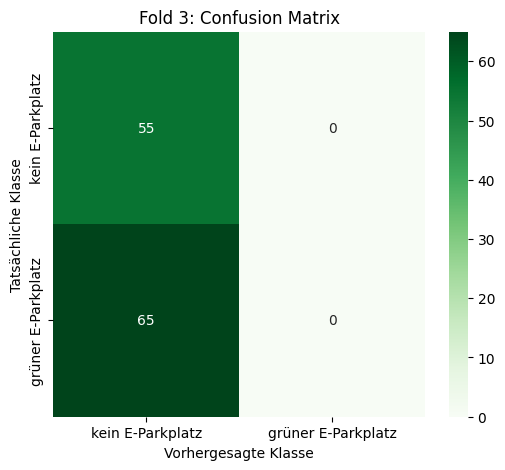

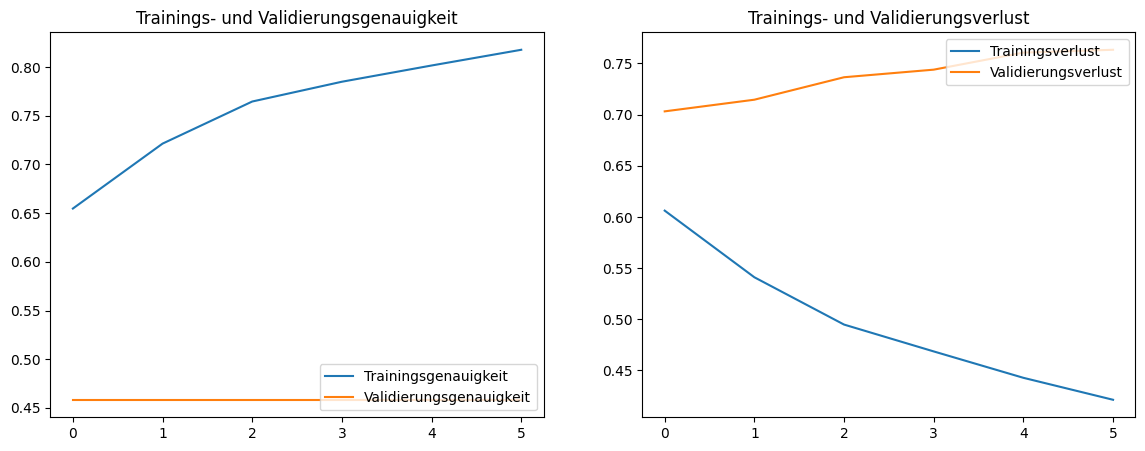


Fold 4 Datenübersicht:


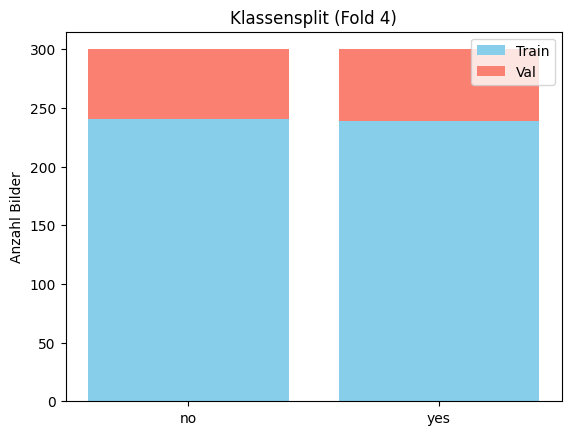

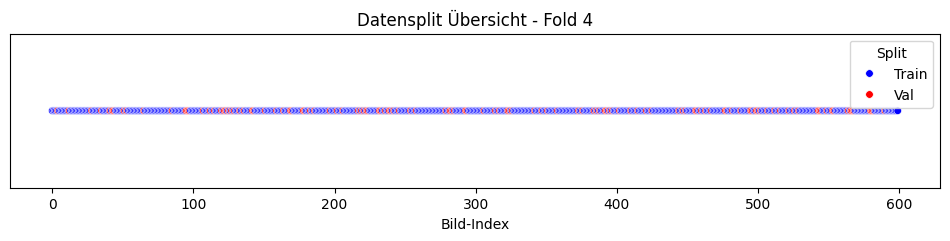

Train shape: (480, 250, 250, 3) (480,)
Val shape: (120, 250, 250, 3) (120,)

Label-Beispiel1: 0 → no
Label-Beispiel2: 1 → yes

Länge Trainingsdaten: 480
Länge Labels: 480
Nach Augmentation: (1920, 250, 250, 3) (1920,)


c:\Users\ruegg\anaconda3\envs\sbdeps\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 250, 250, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 250, 250, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 62, 62, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 62, 62, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,785 (432.75 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6101 - loss: 0.6583
Epoch 1: val_accuracy improved from -inf to 0.51667, saving model to model_fold_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.6109 - loss: 0.6575 - val_accuracy: 0.5167 - val_loss: 0.6929 - learning_rate: 1.0000e-04
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6962 - loss: 0.5781
Epoch 2: val_accuracy improved from 0.51667 to 0.52500, saving model to model_fold_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.6964 - loss: 0.5780 - val_accuracy: 0.5250 - val_loss: 0.6871 - learning_rate: 1.0000e-04
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7229 - loss: 0.5343
Epoch 3: val_accuracy did not improve from 0.52500
60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7229 - loss: 0.5344 - val_accuracy: 0.4917 - val_loss: 0.6922 - learning_rate: 1.0000e-04
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7313 - loss: 0.5328
Epoch 4: val_accuracy did not improve from 0.52500
60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7316 - loss: 0.5325 - val_accuracy: 0.4917 - val_loss: 0.7328 - learning_rate: 1.0000e-04
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7598 - loss: 0.4978
Epoch 5: val_accuracy did not improve from 0.52500
60/60 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.7601 - loss: 0.4977 - val_accuracy: 0.4917 - val_loss: 0.7643 - learning_rate: 1.0000e-04
Epoch 6/15
60/60 ━━━━━━━━

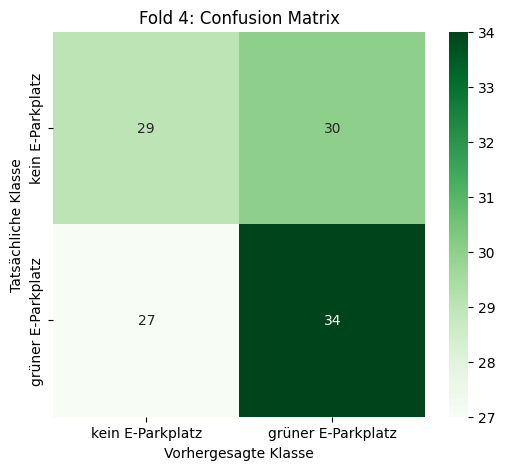

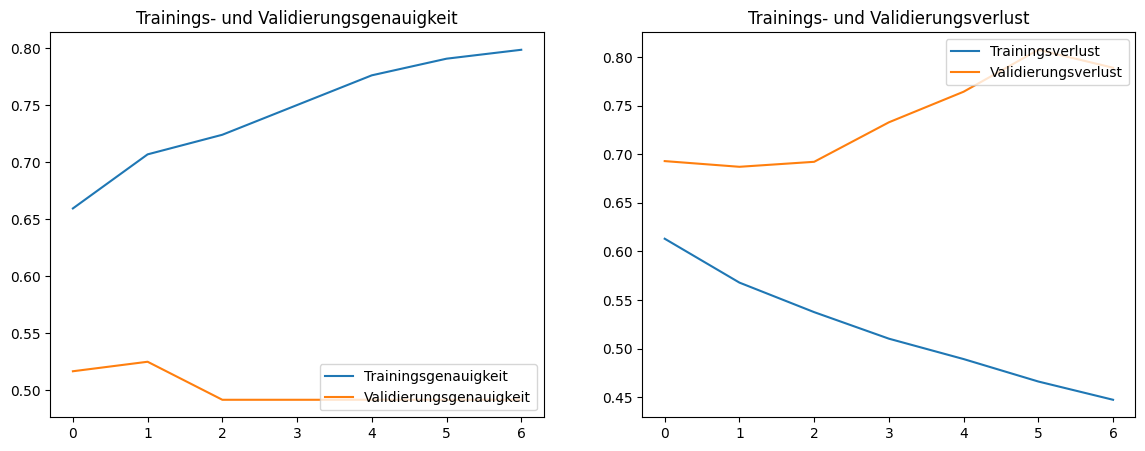


Fold 5 Datenübersicht:


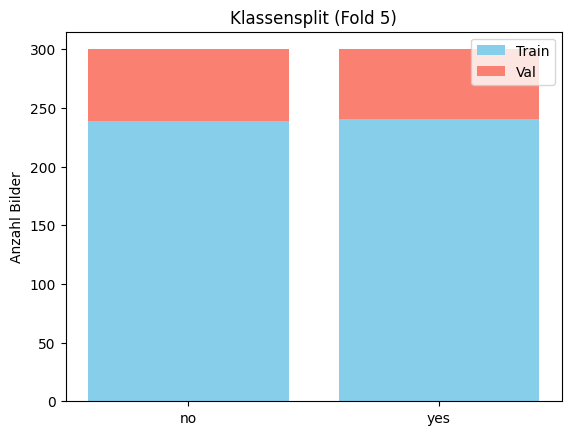

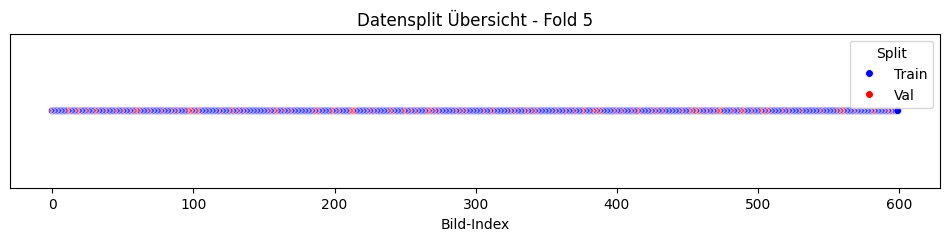

Train shape: (480, 250, 250, 3) (480,)
Val shape: (120, 250, 250, 3) (120,)

Label-Beispiel1: 0 → no
Label-Beispiel2: 1 → yes

Länge Trainingsdaten: 480
Länge Labels: 480
Nach Augmentation: (1920, 250, 250, 3) (1920,)


c:\Users\ruegg\anaconda3\envs\sbdeps\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 250, 250, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 250, 250, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 62, 62, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 62, 62, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,785 (432.75 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5580 - loss: 0.7829
Epoch 1: val_accuracy improved from -inf to 0.49167, saving model to model_fold_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.5586 - loss: 0.7814 - val_accuracy: 0.4917 - val_loss: 0.6967 - learning_rate: 1.0000e-04
Epoch 2/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6886 - loss: 0.5885
Epoch 2: val_accuracy improved from 0.49167 to 0.50000, saving model to model_fold_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.6885 - loss: 0.5884 - val_accuracy: 0.5000 - val_loss: 0.6870 - learning_rate: 1.0000e-04
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7175 - loss: 0.5603
Epoch 3: val_accuracy improved from 0.50000 to 0.61667, saving model to model_fold_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.7175 - loss: 0.5603 - val_accuracy: 0.6167 - val_loss: 0.6724 - learning_rate: 1.0000e-04
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7424 - loss: 0.5272
Epoch 4: val_accuracy improved from 0.61667 to 0.70833, saving model to model_fold_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.7424 - loss: 0.5271 - val_accuracy: 0.7083 - val_loss: 0.6644 - learning_rate: 1.0000e-04
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7346 - loss: 0.5176
Epoch 5: val_accuracy did not improve from 0.70833
60/60 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.7349 - loss: 0.5173 - val_accuracy: 0.6750 - val_loss: 0.6467 - learning_rate: 1.0000e-04
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7724 - loss: 0.4824
Epoch 6: val_accuracy did not improve from 0.70833
60/60 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.7725 - loss: 0.4823 - val_accuracy: 0.7083 - val_loss: 0.6302 - learning_rate: 1.0000e-04
Epoch 7/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7858 - loss: 0.4597
Epoch 7: val_accuracy improved from 0.70833 to 0.74167, saving model to model_fold_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.7858 - loss: 0.4596 - val_accuracy: 0.7417 - val_loss: 0.5994 - learning_rate: 1.0000e-04
Epoch 8/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8030 - loss: 0.4481
Epoch 8: val_accuracy did not improve from 0.74167
60/60 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.8030 - loss: 0.4481 - val_accuracy: 0.6250 - val_loss: 0.6122 - learning_rate: 1.0000e-04
Epoch 9/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7846 - loss: 0.4303
Epoch 9: val_accuracy improved from 0.74167 to 0.76667, saving model to model_fold_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7849 - loss: 0.4302 - val_accuracy: 0.7667 - val_loss: 0.5325 - learning_rate: 1.0000e-04
Epoch 10/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8090 - loss: 0.4070
Epoch 10: val_accuracy did not improve from 0.76667
60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8092 - loss: 0.4070 - val_accuracy: 0.6583 - val_loss: 0.5890 - learning_rate: 1.0000e-04
Epoch 11/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8491 - loss: 0.3845
Epoch 11: val_accuracy did not improve from 0.76667
60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8490 - loss: 0.3845 - val_accuracy: 0.6417 - val_loss: 0.6031 - learning_rate: 1.0000e-04
Epoch 12/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8303 - loss: 0.3938
Epoch 12: val_accuracy improved from 0.76667 to 0.82500, saving model to model_fold_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8303 - loss: 0.3936 - val_accuracy: 0.8250 - val_loss: 0.4729 - learning_rate: 1.0000e-04
Epoch 13/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8420 - loss: 0.3803
Epoch 13: val_accuracy did not improve from 0.82500
60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8420 - loss: 0.3802 - val_accuracy: 0.6917 - val_loss: 0.5974 - learning_rate: 1.0000e-04
Epoch 14/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8670 - loss: 0.3327
Epoch 14: val_accuracy did not improve from 0.82500
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8668 - loss: 0.3330 - val_accuracy: 0.6333 - val_loss: 0.7029 - learning_rate: 1.0000e-04
Epoch 15/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8396 - loss: 0.3687
Epoch 15: val_accuracy improved from 0.82500 to 0.84167, saving model to model_fold_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8397 - loss: 0.3684 - val_accuracy: 0.8417 - val_loss: 0.4407 - learning_rate: 1.0000e-04
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step
                        precision    recall  f1-score   support

  kein E-Parkplatz (0)       0.88      0.80      0.84        61
grüner E-Parkplatz (1)       0.81      0.88      0.85        59

              accuracy                           0.84       120
             macro avg       0.84      0.84      0.84       120
          weighted avg       0.84      0.84      0.84       120



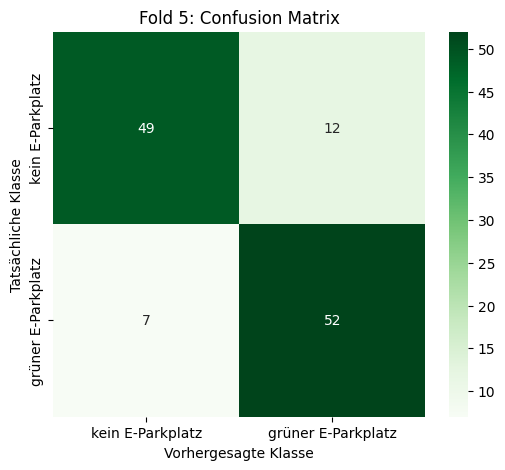

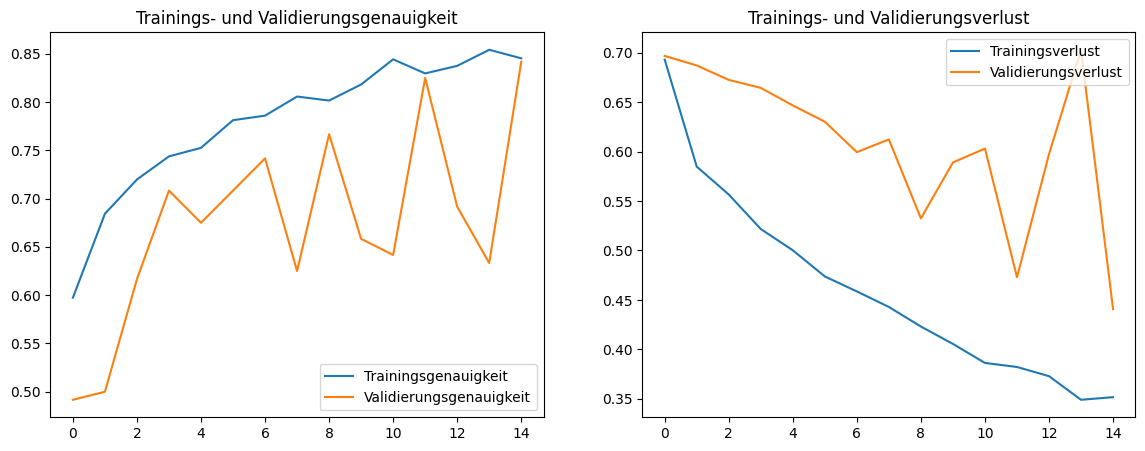

In [ ]:
# K-Fold vorbereiten - Cross Validation 
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold_no = 1
acc_per_fold = []
loss_per_fold = []

for train_index, val_index in kf.split(x_data):
    print(f'\n====================')
    print(f'Fold {fold_no} Datenübersicht:')

    # Aufteilen in Training / Validation
    x_train, x_val = x_data[train_index], x_data[val_index]
    y_train, y_val = y_data[train_index], y_data[val_index]

    # Ursprüngliche Labels (ohne Augmentation!) → Verteilung im Original-Split
    train_labels = y_data[train_index].astype(int)
    val_labels = y_data[val_index].astype(int)

    # Anzahl pro Klasse
    train_no = np.sum(train_labels == 0)
    train_yes = np.sum(train_labels == 1)
    val_no = np.sum(val_labels == 0)
    val_yes = np.sum(val_labels == 1)

    labels_classes = ['no', 'yes']
    train_counts = [train_no, train_yes]
    val_counts = [val_no, val_yes]

    x = np.arange(len(labels_classes))

    fig, ax = plt.subplots()
    ax.bar(x, train_counts, label='Train', color='skyblue')
    ax.bar(x, val_counts, bottom=train_counts, label='Val', color='salmon')

    ax.set_ylabel('Anzahl Bilder')
    ax.set_title(f'Klassensplit (Fold {fold_no})')
    ax.set_xticks(x)
    ax.set_xticklabels(labels_classes)
    ax.legend()

    plt.show()
   
    
    # Visualisieren, welche Bilder train / val sind
    split_labels = []
    for idx in range(len(x_data)):
        if idx in train_index:
            split_labels.append('Train')
        elif idx in val_index:
            split_labels.append('Val')
        else:
            split_labels.append('Unknown')

    df = pd.DataFrame({'Index': range(len(x_data)), 'Split': split_labels})

    # Plot
    plt.figure(figsize=(12, 2))
    sns.scatterplot(data=df, x='Index', y=[1]*len(df), hue='Split', palette={'Train': 'blue', 'Val': 'red'}, legend='full', s=30)
    plt.title(f'Datensplit Übersicht - Fold {fold_no}')
    plt.yticks([])
    plt.xlabel('Bild-Index')
    plt.show()


    # Shape vor Augmentation 
    print("Train shape:", x_train.shape, y_train.shape)
    print("Val shape:", x_val.shape, y_val.shape)

    # Beispiel-Labels anzeigen
    print("\nLabel-Beispiel1:", int(y_train[0]), "→", labels[int(y_train[0])])
    print("Label-Beispiel2:", int(y_train[-1]), "→", labels[int(y_train[-1])])

    # Anzahl Daten
    print("\nLänge Trainingsdaten:", len(x_train))
    print("Länge Labels:", len(y_train))

    # Data Augmentation auf Trainingsdaten
    x_train, y_train = rotate_and_flip_images(x_train, y_train)
    print("Nach Augmentation:", x_train.shape, y_train.shape)
    
    # Model erzeugen
    model = create_model()

    # Create callbacks including checkpoint
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
    checkpoint = ModelCheckpoint(
        f'model_fold_{fold_no}.h5', 
        monitor='val_accuracy', 
        save_best_only=True,
        mode='max',
        verbose=1
    )

    callbacks = [early_stop, lr_scheduler, checkpoint]

    history = train_model(
        model, x_train, y_train, x_val, y_val,
        batch_size=32,
        epochs=15,
        callbacks=callbacks
    )

    # laod the best weights
    model.load_weights(f'model_fold_{fold_no}.h5')

# rest of your code ...

    # Bilder der Resultate 

    # Vorhersagen
    predictions = model.predict(x_val)
    predictions = (predictions > 0.5).astype("int32").reshape(-1)
    y_val_int = y_val.astype(int)

    # Classification Report
    print(classification_report(y_val_int, predictions, target_names=['kein E-Parkplatz (0)', 'grüner E-Parkplatz (1)']))

    # Confusion Matrix
    cm = confusion_matrix(y_val_int, predictions)
    labels_cm = ['kein E-Parkplatz', 'grüner E-Parkplatz']

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=labels_cm,
                yticklabels=labels_cm)
    plt.xlabel('Vorhergesagte Klasse')
    plt.ylabel('Tatsächliche Klasse')
    plt.title(f'Fold {fold_no}: Confusion Matrix')
    plt.show()

    # Loss & Accuracy Plot
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Trainingsgenauigkeit')
    plt.plot(epochs_range, val_acc, label='Validierungsgenauigkeit')
    plt.legend(loc='lower right')
    plt.title('Trainings- und Validierungsgenauigkeit')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Trainingsverlust')
    plt.plot(epochs_range, val_loss, label='Validierungsverlust')
    plt.legend(loc='upper right')
    plt.title('Trainings- und Validierungsverlust')

    plt.show()

    # fold_no am Ende des Loops hochzählen
    fold_no += 1



# Evaluating results

In [7]:
'''
# Parameter für K-Fold Cross Validation
BATCH_SIZE = 16
EPOCHS = 30
SPLITS = 10

kf = KFold(n_splits=SPLITS, shuffle=True, random_state=42)

fold_no = 1
acc_per_fold, loss_per_fold = [], []

for train_index, val_index in kf.split(x_data):
    
    x_train, x_val, y_train, y_val = x_data[train_index], x_data[val_index], y_data[train_index], y_data[val_index]
    x_train, y_train = rotate_and_flip_images(x_train, y_train)
    model = create_model()

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
    checkpoint = ModelCheckpoint(f'model_fold_{fold_no}.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

    callbacks = [early_stop, lr_scheduler, checkpoint]

    history = train_model(
        model, x_train, y_train, x_val, y_val,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=callbacks
    )

    model.load_weights(f'model_fold_{fold_no}.h5')
    predictions = model.predict(x_val)
    predictions = (predictions > 0.5).astype("int32").reshape(-1)
    y_val_int = y_val.astype(int)

    print(classification_report(y_val_int, predictions, target_names=['kein E-Parkplatz (0)', 'grüner E-Parkplatz (1)']))

    fold_no += 1
'''

'\n# Parameter für K-Fold Cross Validation\nBATCH_SIZE = 16\nEPOCHS = 30\nSPLITS = 10\n\nkf = KFold(n_splits=SPLITS, shuffle=True, random_state=42)\n\nfold_no = 1\nacc_per_fold, loss_per_fold = [], []\n\nfor train_index, val_index in kf.split(x_data):\n\n    x_train, x_val, y_train, y_val = x_data[train_index], x_data[val_index], y_data[train_index], y_data[val_index]\n    x_train, y_train = rotate_and_flip_images(x_train, y_train)\n    model = create_model()\n\n    early_stop = EarlyStopping(monitor=\'val_loss\', patience=5, restore_best_weights=True)\n    lr_scheduler = ReduceLROnPlateau(monitor=\'val_loss\', factor=0.5, patience=3, min_lr=1e-5)\n    checkpoint = ModelCheckpoint(f\'model_fold_{fold_no}.h5\', monitor=\'val_accuracy\', save_best_only=True, mode=\'max\', verbose=1)\n\n    callbacks = [early_stop, lr_scheduler, checkpoint]\n\n    history = train_model(\n        model, x_train, y_train, x_val, y_val,\n        batch_size=BATCH_SIZE,\n        epochs=EPOCHS,\n        callbac